# Feature Extraction using DMD

This notebook highlights the process of extracting features using DMD.

*In this notebook we will be using preprocessed signals, which have been processed using steps higlighted in the processing notebook


## 0. Logistics

In [86]:
#loading a datasample for extracting features
from wfdb.io import rdrecord
from wfdb import Record

record:Record=rdrecord('../processed1/JS00001')



[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

## 1 Augumentaion 

For DMD to work properly the matrix has to be augumented, i.e increase number of rows the following function ws used for achieving this

In [57]:
import numpy as np 

In [58]:
def AugMat(signal: np.ndarray, h: int):
    n, m = signal.shape
    aug = []
    for i in range(n):
        for x in range(h):
            row = signal[i][x:m-h+x]
            aug.append(row)
    return np.vstack(aug)

In [59]:
augFactor=200

aug=AugMat(signalDf.to_numpy().T,augFactor)

print("Previous Dimension", signalDf.to_numpy().T.shape)

print("Current Dimension", aug.shape)

Previous Dimension (12, 5000)
Current Dimension (2400, 4800)


## 2 DMD

pyDMD was used to apply the DMD model. 

In [60]:
import pydmd as dmd

In [61]:
DMD=dmd.DMD()
DMD.fit(aug)


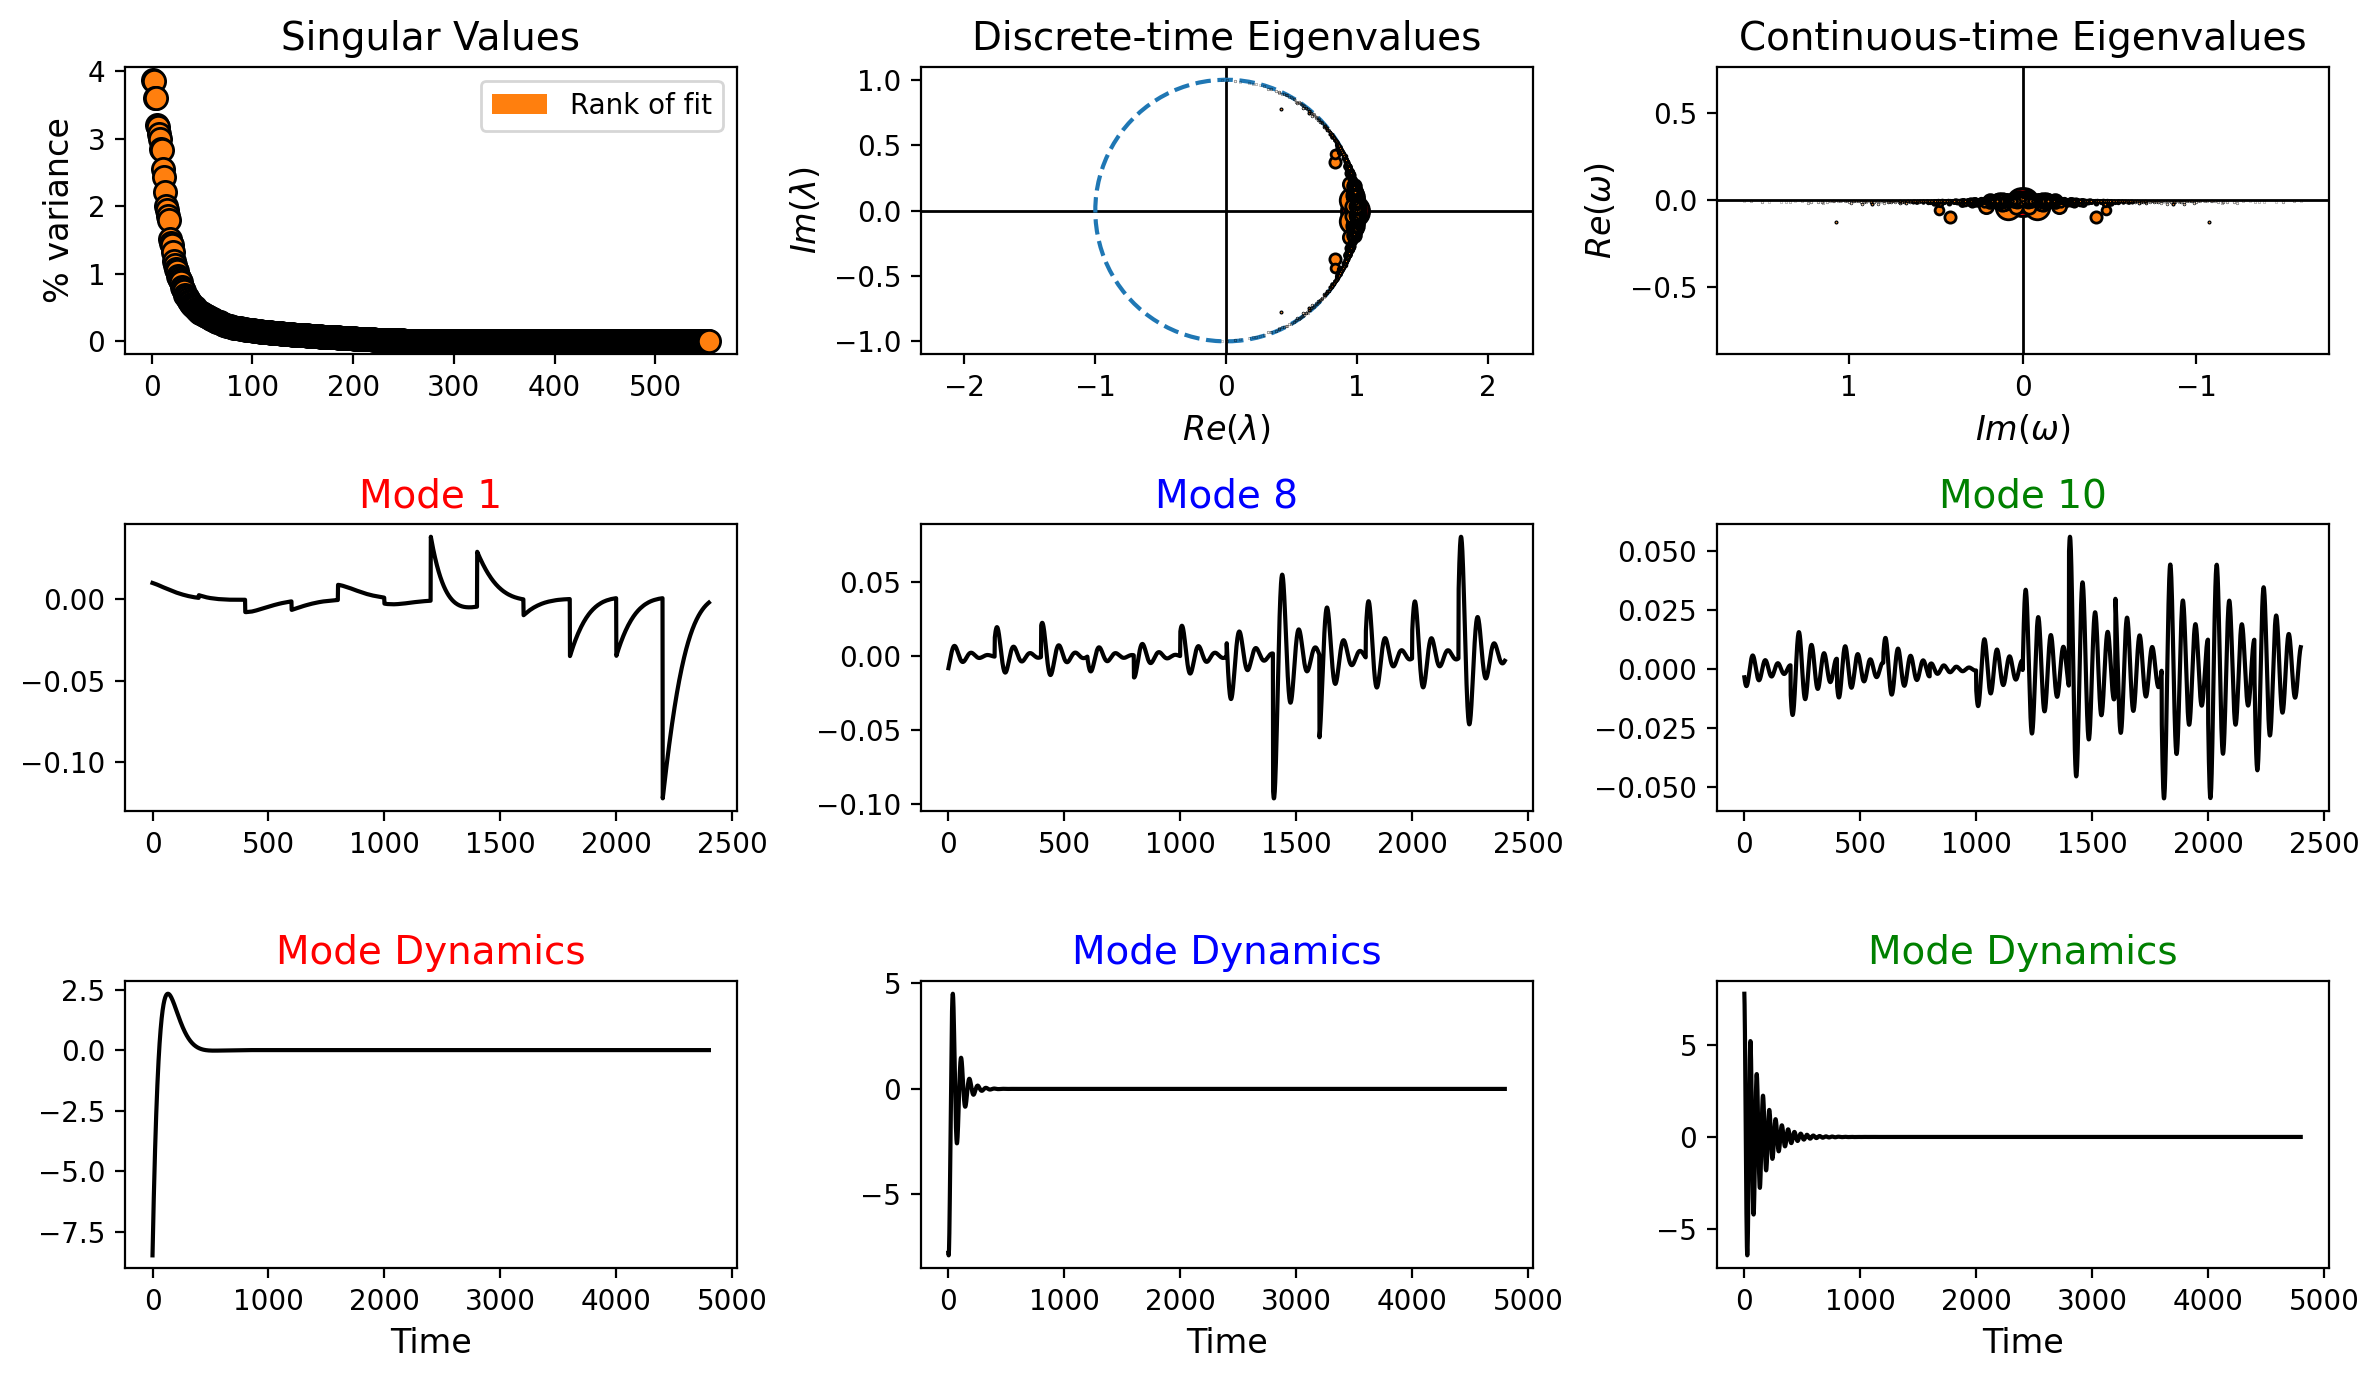

In [62]:
from pydmd.plotter import plot_summary
plot_summary(
    DMD, 
    figsize=(12, 7),
    index_modes=(0,7, 9),
    order="D",
    mode_cmap="seismic",
    dynamics_color="k",
    flip_continuous_axes=True,
    max_sval_plot=553,
)

## 3. Features from DMD 

The features extracted from the DMD were based on their eigenvalue and modes (eigenvector). 

In [63]:
modes=DMD.modes 
eigs=DMD.eigs

\begin{align*} &{{{\bf \Phi }}} = \left[ {{\boldsymbol{\phi }}\ _1, \ldots,{\boldsymbol{\phi }}\ _i, \ldots,{\boldsymbol{\phi }}\ _I} \right] \\ &{{{\bf \Lambda }}} = \left[ {\begin{array}{ccccc} {\lambda_1}&0& \ldots &\ldots &0\\ 0& \ddots &0&0 & \vdots \\ \vdots &0&{\lambda_i}&0&\vdots\\ \ldots &0 &0 &\ddots &0\\ 0& \ldots &\ldots &0&{\lambda_I} \end{array}} \right] \end{align*}

If λ<sub>i</sub> < 1 for modes[i] it is considered stable so we split the modes and eigenvalues as such to extract the features

\begin{equation*} {{\bf \Phi }} = \left[ {{{{\bf \Phi }}^u},{{{\bf \Phi }}^s}} \right] \Leftrightarrow {{\bf \Lambda }} = \left[ {\begin{array}{lll} {{{{\bf \Lambda }}^u}}&0\\ 0&{{{{\bf \Lambda }}^s}} \end{array}} \right]  \end{equation*}

In [64]:
Lambda_ind_u = np.where(np.abs(eigs) > 1)
Lambda_ind_s = np.where(np.abs(eigs) < 1)

Lambda_u = eigs[Lambda_ind_u] #unstable eigen values
Lambda_s = eigs[Lambda_ind_s] #stable eigen values


We can now count the number of stable and unstable modes

In [65]:
#number of Stable and unstable modes
numS=Lambda_s.shape[0]
numU=Lambda_u.shape[0]

Because we augumented the matrix we have to restack it so thast the 12 modes are presereved

In [66]:
restacked=modes.reshape(12, augFactor, -1).mean(axis=1)

After restacking we can sperate out the stable and unstable modes into  Φ<sub>s</sub> and Φ<sub>u</sub> for stable and unstable modes respectfully

In [67]:
Phi_u = restacked[:,Lambda_ind_u].reshape((12,Lambda_u.shape[0])) #unstable modes
Phi_s = restacked[:,Lambda_ind_s].reshape((12,Lambda_s.shape[0])) #stable modes

### 3.1 Ratio of unstable modes to 

Simply this is number of unstable modes by total modes

\begin{equation*} {R_N} = \frac{D}{{(D + C)}}  \end{equation*}



In [68]:
R_N=(numU)/(numU+numS)

### 3.2 Ratio of sum of unstable lamdas to total sum of lambdas

\begin{equation*} {R_\lambda } = \frac{{\sum\nolimits_{d = 1}^D {\left| {\lambda \ _d^u} \right|} }}{{\sum\nolimits_{d = 1}^D {\left| {\lambda \ _d^u} \right|} + \sum\nolimits_{c = 1}^C {\left| {\lambda \ _c^s} \right|} }} \end{equation*}

In [69]:
R_L=np.sum(np.abs(Lambda_u))/(np.sum(np.abs(Lambda_s))+np.sum(np.abs(Lambda_u)))

### 3.3 Min and Max Lambda values

\begin{align*} &{\lambda _{\min }} = \min \left({\left| {{{{\bf \Lambda }}^s}} \right|} \right)\\ &{\lambda _{\max }} = \max \left({\left| {{{{\bf \Lambda }}^u}} \right|} \right)  \end{align*}

In [70]:
Lam_min = np.min(np.abs(Lambda_s),initial = -1 )
Lam_max = np.max(np.abs(Lambda_u), initial = -1 )

### 3.4 Ratio of sum of magnitudes of all modes and phases of all modes

\begin{equation*} {R_M} = \frac{{\sum\nolimits_{l = 1}^{12} {\sum\nolimits_{d = 1}^D {\left| {{\boldsymbol{\phi }}\ _d^u\ \left(l \right)} \right|} } }}{{\sum\nolimits_{l = 1}^{12} {\sum\nolimits_{d = 1}^D {\left| {{\boldsymbol{\phi }}\ _d^u\ \left(l \right)} \right|} } + \sum\nolimits_{l = 1}^{12} {\sum\nolimits_{c = 1}^C {\left| {{\boldsymbol{\phi }}\ _c^s\ \left(l \right)} \right|} } }}  \end{equation*}

\begin{align*} &{R_P}\\ & = \frac{{\sum\nolimits_{l = 1}^{12} {\sum\nolimits_{d = 1}^D {angle\left({{\boldsymbol{\phi }}\ _d^u\ \left(l \right)} \right)} } }}{{\sum\nolimits_{l = 1}^{12} {\sum\nolimits_{d = 1}^D {angle\left({{\boldsymbol{\phi }}\ _d^u \left(l \right)} \right)} } \!+\! \sum\nolimits_{l = 1}^{12}\! {\sum\nolimits_{c = 1}^C {angle\left({{\boldsymbol{\phi }}\ _c^s \left(l \right)} \right)} } }}  \end{align*}

In [71]:
R_M = np.sum(np.sum(np.abs(Phi_u), axis = 1))/(np.sum(np.sum(np.abs(Phi_u), axis = 1)) + np.sum(np.sum(np.abs(Phi_s), axis = 1)))
R_P = np.sum(np.sum(np.angle(Phi_u), axis = 1))/(np.sum(np.sum(np.angle(Phi_u), axis = 1)) +  np.sum(np.sum(np.angle(Phi_s), axis = 1)))

### 3.5 Sum of Magnitudes and phases for stable and unstable modes

\begin{align*} &{\boldsymbol{{\rm M}}}_{lead} = \frac{{\sum\nolimits_{c = 1}^C {\left| {{\boldsymbol{\phi }}\ _c} \right|} }}{C} \tag{1} \\ &{\boldsymbol{{\rm P}}}_{lead} = \frac{{\sum\nolimits_{c = 1}^C {angle\left({{\boldsymbol{\phi }}\ _c} \right)} }}{C} \tag{2}\end{align*}

where this is done for both stable and unstable leads and C denotes the number of modes( i.e stable or unstable). 

In [72]:
#for unstble modes
M_u = np.mean(np.abs(Phi_u), axis=1)
P_u = np.mean(np.angle(Phi_u-np.angle(Phi_u[0])), axis=1)


#for stable modes
M_s = np.mean(np.abs(Phi_s), axis=1)
P_s = np.mean(np.angle(Phi_s-np.angle(Phi_s[0])), axis=1)



These are 12 length vectors which each of the elements representing a lead. Taking in account both the stable and unstable leads there are 2\*2\*12=48 features from (1) and (2)

Combining with all from 5.1, 5.2 5.3 and 5.4 there are a total of 54 features.



In [77]:
from IPython.display import Markdown, display

def print_md(string):
    display(Markdown(string))



print_md(f'**R_N:** {R_N:.3f}, **R_L:** {R_L:.3f}, **R_M:** {R_M:.3f}, **R_P:** {R_P:.3f}, **Lam_min:** {Lam_min:.3f}, **Lam_max:** {Lam_max:.3f}')
print_md(f'**M_s:** {", ".join(f"{x:.3f}" for x in M_s)}')
print_md(f'**P_s:** {", ".join(f"{x:.3f}" for x in P_s)}')
print_md(f'**M_u:** {", ".join(f"{x:.3f}" for x in M_u)}')
print_md(f'**P_u:** {", ".join(f"{x:.3f}" for x in P_u)}')

**R_N:** 0.002, **R_L:** 0.002, **R_M:** 0.031, **R_P:** 0.250, **Lam_min:** -1.000, **Lam_max:** 1.007

**M_s:** 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.002, 0.001, 0.001, 0.001, 0.001, 0.002

**P_s:** 1.565, 0.364, -0.421, -0.859, 0.660, 0.068, -0.198, 0.063, 0.074, 0.193, 0.228, 0.120

**M_u:** 0.014, 0.010, 0.004, 0.013, 0.008, 0.003, 0.010, 0.030, 0.036, 0.026, 0.021, 0.017

**P_u:** 3.142, 3.142, 3.142, 3.142, 3.142, 3.142, 3.142, 3.142, 3.142, 3.142, 3.142, 3.142